# Learning Python Analytics

The dataset is exported from Hevy, the application I use to track my workouts.
Here I provide visualizations and analytics of this dataset to learn Python.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set default figure size
plt.rcParams['figure.figsize'] = [21, 16]

column_names = [
    'title', 'start_time', 'end_time', 'description', 'exercise_title',
    'superset_id', 'exercise_notes', 'set_index', 'set_type', 'weight_kg',
    'reps', 'distance_km', 'duration_seconds', 'rpe'
]

df = pd.read_csv("workout_data.csv", names=column_names, header=0)

In [2]:
df.head()

,title,start_time,end_time,description,exercise_title,superset_id,exercise_notes,set_index,set_type,weight_kg,reps,distance_km,duration_seconds,rpe
0,Shoulders,"13 Sep 2024, 14:11","13 Sep 2024, 15:19",NaN,Pamela Reif Ab Workout,NaN,NaN,0,normal,NaN,NaN,NaN,600.0,NaN
1,Shoulders,"13 Sep 2024, 14:11","13 Sep 2024, 15:19",NaN,Shoulder Press (Dumbbell),NaN,NaN,0,warmup,32.0,12.0,NaN,NaN,NaN
2,Shoulders,"13 Sep 2024, 14:11","13 Sep 2024, 15:19",NaN,Shoulder Press (Dumbbell),NaN,NaN,1,normal,48.0,10.0,NaN,NaN,NaN
3,Shoulders,"13 Sep 2024, 14:11","13 Sep 2024, 15:19",NaN,Shoulder Press (Dumbbell),NaN,NaN,2,normal,64.0,10.0,NaN,NaN,NaN
4,Shoulders,"13 Sep 2024, 14:11","13 Sep 2024, 15:19",NaN,Shoulder Press (Dumbbell),NaN,NaN,3,normal,72.0,6.0,NaN,NaN,NaN


### Cleaning the DataFrame

In [3]:
def clean_and_prepare(df: pd.DataFrame) -> pd.DataFrame:
    """Cleaning and preparation of pd.DataFrame

    Args:
        df (pd.DataFrame): Input Data Frame

    Returns:
        pd.DataFrame: Cleaned and Converted Data Frame
    """
    def fill_and_convert(col: pd.Series, replacement, type) -> pd.Series:
        """Helper function to fill and convert data quickly

        Args:
            col (pd.Series): input pd.Series (Column)
            replacement (_type_): Value that replaces the NaN-s
            type (_type_): type of conversion

        Returns:
            pd.Series: filled Column
        """
        col = col.fillna(replacement)
        return col.astype(type)
    
    # Title conversion
    df.title = fill_and_convert(df.title, '', str)
    
    # Description conversion
    df.description = fill_and_convert(df.description, '', str)
    
    # Superset conversion
    df.superset_id = fill_and_convert(df.superset_id, '', str)
    
    # Exercise notes conversion
    df.exercise_notes = fill_and_convert(df.exercise_notes, '', str)
    
    # Weight fill and conversion
    df.weight_kg = fill_and_convert(df.weight_kg, 0, int)
    
    # Reps conversion
    df.reps = fill_and_convert(df.reps, 0, int)
    
    # Distance conversion
    df.distance_km = fill_and_convert(df.distance_km, 0, np.float64)
    
    # Duration conversion - and rounding to integer if not 0
    df.duration_seconds = df.duration_seconds.apply(lambda x: int(round(x)) if pd.notna(x) else 0)
    
    # RPE conversion - if applies
    df.rpe = df.rpe.apply(lambda x: x if pd.notna(x) else 0.0)
    
    # Set Type conversion to category
    df.set_type = df.set_type.astype('category')

    # Start Time conversion to datetime
    df.start_time = pd.to_datetime(df.start_time, format="%d %b %Y, %H:%M")
    
    # End Time conversion to datetime
    df.end_time = pd.to_datetime(df.end_time, format="%d %b %Y, %H:%M")
    
    # Returned value: cleaned and prepared pd.DataFrame
    return df


df = clean_and_prepare(df)

#### Adding Calculated Fields

In [4]:
def substring_between_brackets(string: str) -> str:
    """Finding a Substring within brackets to extract equipment

    Args:
        string (str): Title of Exercise

    Returns:
        str: Extracted equipment
    """
    start = string.find('(') + 1
    end = string.find(')')
    return string[start:end] if start != -1 and end != -1 else ""


# Calculating the duration of workout
df['workout_duration'] = (df.end_time - df.start_time).dt.total_seconds() / 60

# Extracting equipment from title
df['equipment'] = df.exercise_title.apply(lambda x: substring_between_brackets(x))

df['set_order'] = df.groupby('start_time').cumcount() + 1

In [5]:
df = df.sort_values(by=['start_time', 'set_order'], 
                    ascending = True,
                    ignore_index=True)
df.head()

,title,start_time,end_time,description,exercise_title,superset_id,exercise_notes,set_index,set_type,weight_kg,reps,distance_km,duration_seconds,rpe,workout_duration,equipment,set_order
0,Cardio sesh 🥵,2023-06-02 17:00:00,2023-06-02 18:04:00,,Treadmill,,,0,normal,0,0,4.0,2700,0.0,64.0,,1
1,Cardio sesh🥵,2023-06-03 10:15:00,2023-06-03 11:01:00,,Treadmill,,,0,normal,0,0,4.0,2700,0.0,46.0,,1
2,Cardio sesh,2023-06-04 19:11:00,2023-06-04 19:56:00,,Treadmill,,,0,normal,0,0,4.0,2700,0.0,45.0,,1
3,Legs Hamstrings,2023-06-05 18:34:00,2023-06-05 19:43:00,,Romanian Deadlift (Dumbbell),,,0,normal,44,12,0.0,0,0.0,69.0,Dumbbell,1
4,Legs Hamstrings,2023-06-05 18:34:00,2023-06-05 19:43:00,,Romanian Deadlift (Dumbbell),,,1,normal,44,10,0.0,0,0.0,69.0,Dumbbell,2


#### Volume Calculations

In [6]:
df['volume_per_exercise'] = df.weight_kg * df.reps

df_total_volume = df.groupby('start_time')['volume_per_exercise'].sum().reset_index()
df_total_volume.columns = ['start_time', 'total_volume']

df_cumulative_volume = df.groupby('start_time')['volume_per_exercise'].cumsum()
df_cumulative_volume.colums = ['start_time', 'cumulative_volume']

Merge volumes to the original dataframe

In [7]:
df_total_volume.head()

,start_time,total_volume
0,2023-06-02 17:00:00,0
1,2023-06-03 10:15:00,0
2,2023-06-04 19:11:00,0
3,2023-06-05 18:34:00,9060
4,2023-06-08 19:38:00,8806


In [8]:
df_cumulative_volume.head()

0      0
1      0
2      0
3    528
4    968
Name: volume_per_exercise, dtype: int64

In [9]:
df = df.merge(df_total_volume, left_on='start_time', right_on='start_time', how='left')

df['cumulative_volume'] = df_cumulative_volume

In [10]:
df.sample(5)

,title,start_time,end_time,description,exercise_title,superset_id,exercise_notes,set_index,set_type,weight_kg,reps,distance_km,duration_seconds,rpe,workout_duration,equipment,set_order,volume_per_exercise,total_volume,cumulative_volume
4501,Legz,2024-06-22 11:24:00,2024-06-22 13:43:00,,Single Leg Press (Machine),,,0,normal,75,10,0.0,0,0.0,139.0,Machine,10,750,17702,4638
1990,Csöcs by the Csöcs,2023-11-14 18:21:00,2023-11-14 20:20:00,,Chest Press (Machine),,,3,normal,77,12,0.0,0,0.0,119.0,Machine,18,924,9788,5814
4567,GM csöcs,2024-06-24 07:19:00,2024-06-24 08:24:00,,Triceps Pushdown,,,0,normal,26,12,0.0,0,0.0,65.0,,21,312,6359,4676
678,Back,2023-07-21 17:14:00,2023-07-21 18:46:00,,Seated Cable Row,,,3,normal,107,8,0.0,0,0.0,92.0,,11,856,9694,5032
1250,Back,2023-09-10 11:21:00,2023-09-10 12:42:00,,Seated Row (Machine),,,2,normal,90,10,0.0,0,0.0,81.0,Machine,13,900,10273,7693


#### Making sure the DataFrame is ordered by Time

C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\125905265.py:6: UserWarning: Glyph 129397 (\N{OVERHEATED FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\125905265.py:6: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\125905265.py:6: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\projects\workout_analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129397 (\N{OVERHEATED FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\projects\workout_analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\projects\workout_analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: Us

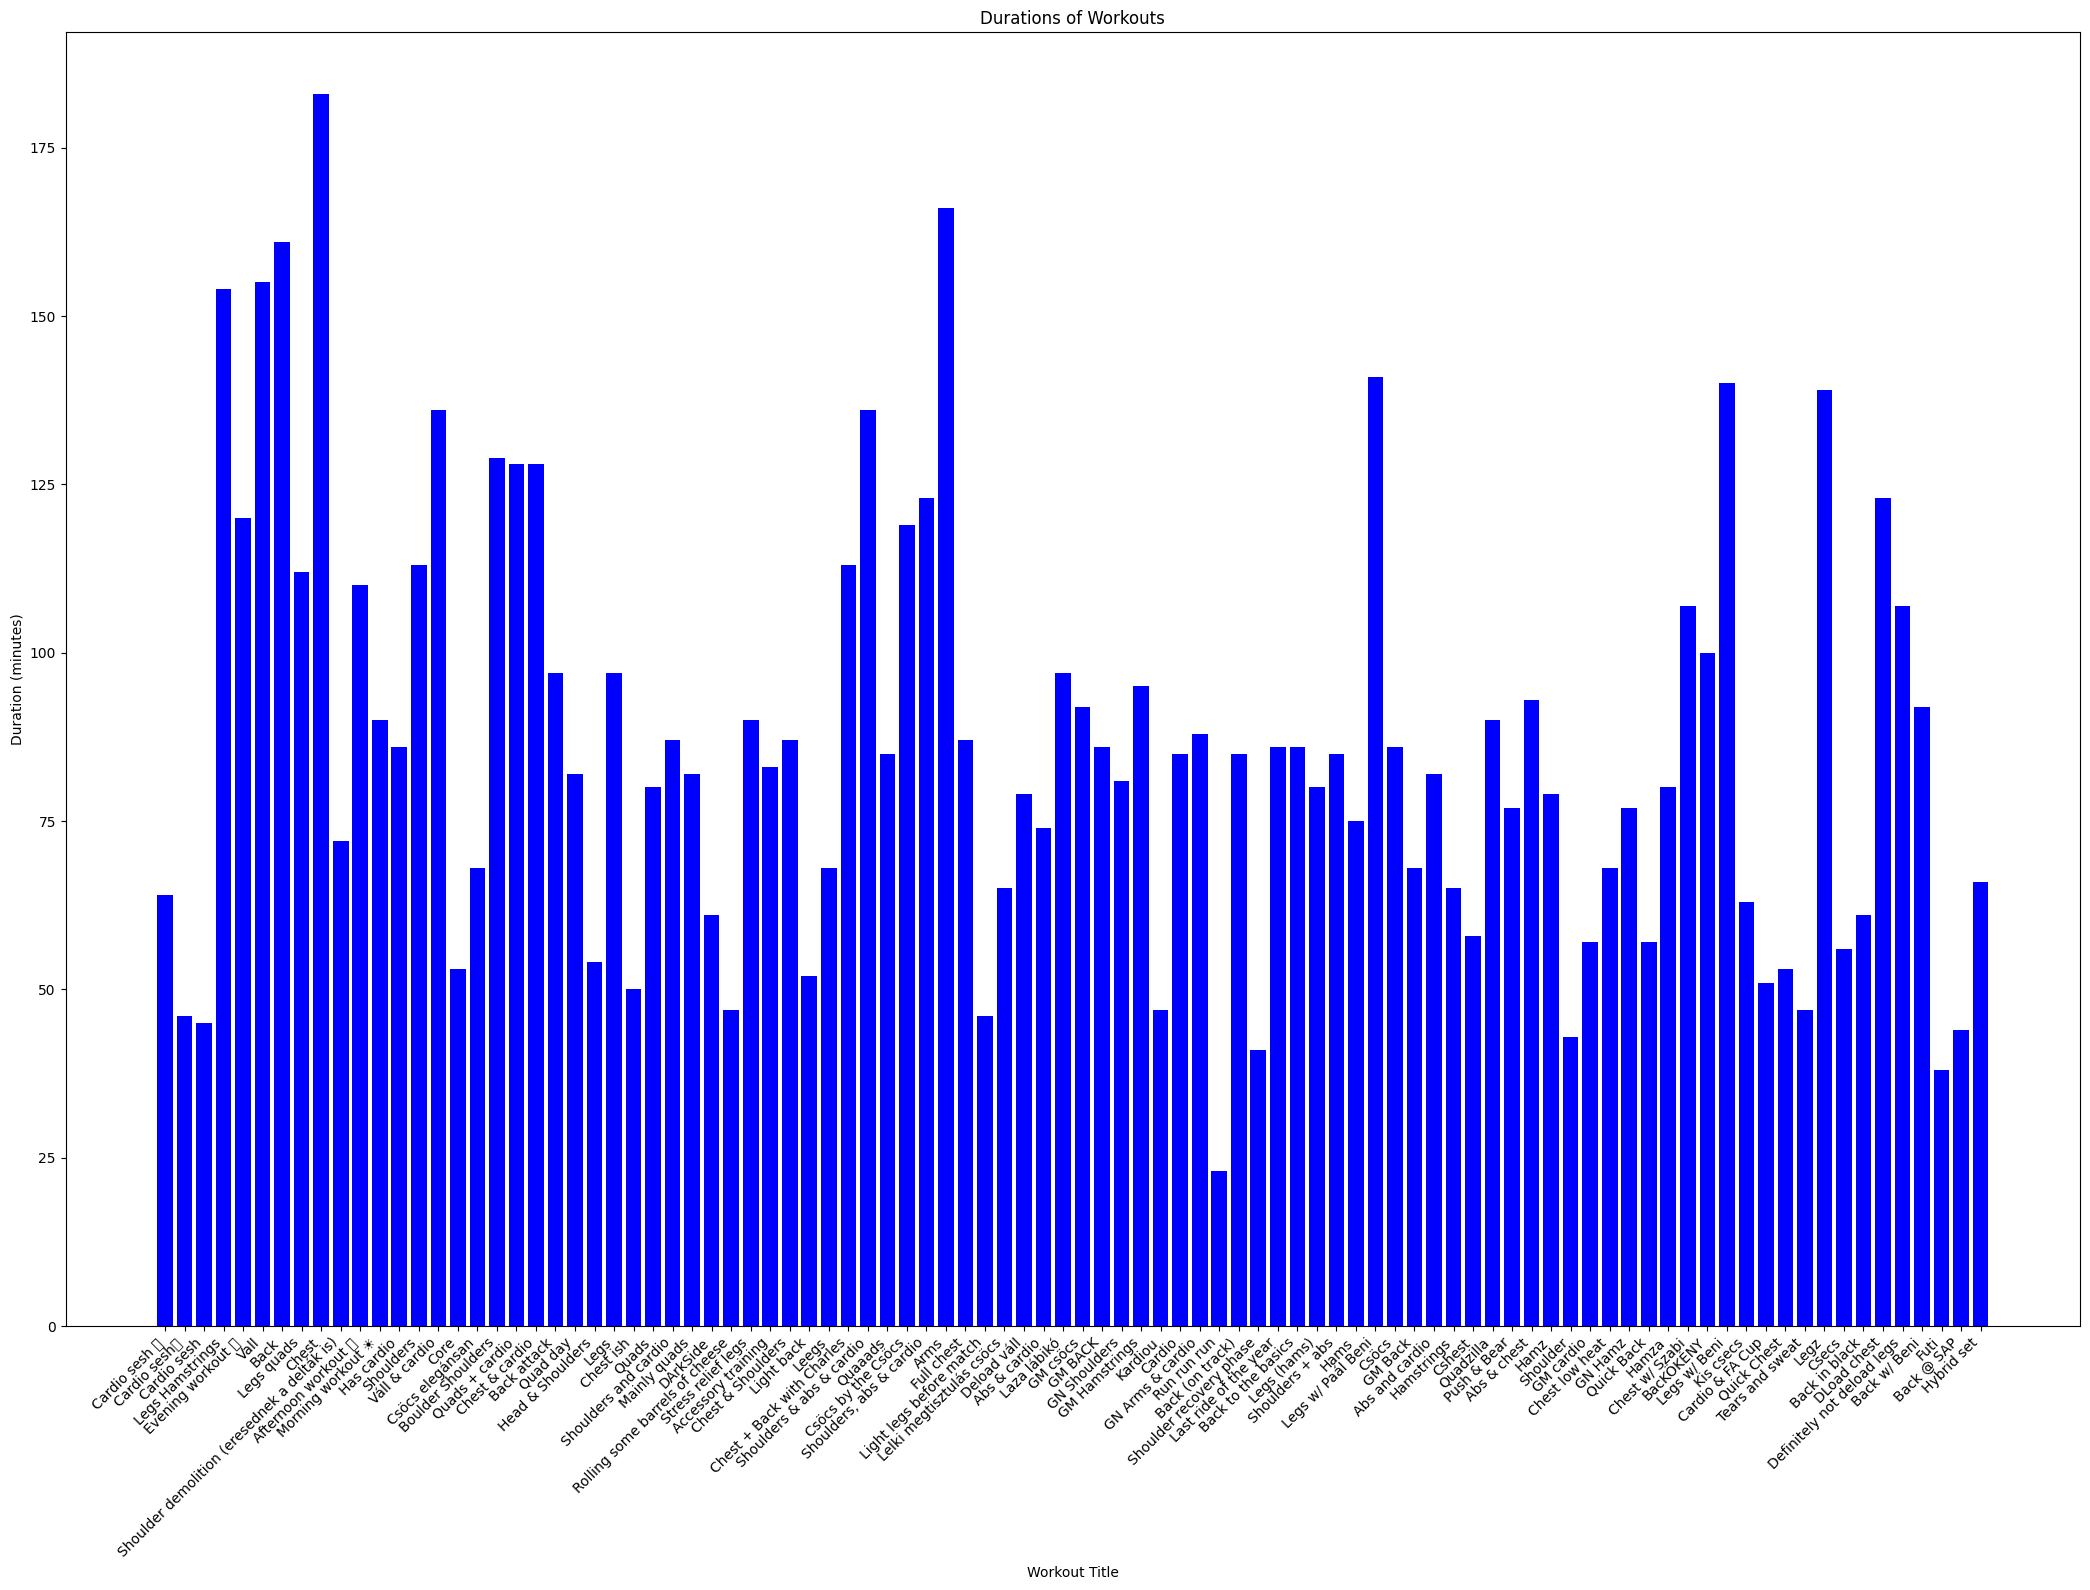

In [11]:
plt.bar(df.title, df.workout_duration, color='b')
plt.xlabel('Workout Title')
plt.ylabel('Duration (minutes)')
plt.title('Durations of Workouts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\3485112451.py:19: UserWarning: Glyph 129397 (\N{OVERHEATED FACE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\3485112451.py:19: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\3485112451.py:19: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\3485112451.py:19: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\3485112451.py:19: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from font(s) Arial.
  plt.tight_layout()
c:\projects\workout_analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129397 (\N{OVERHEATED FACE}) missing from font(s) Arial.
  fig.canvas.prin

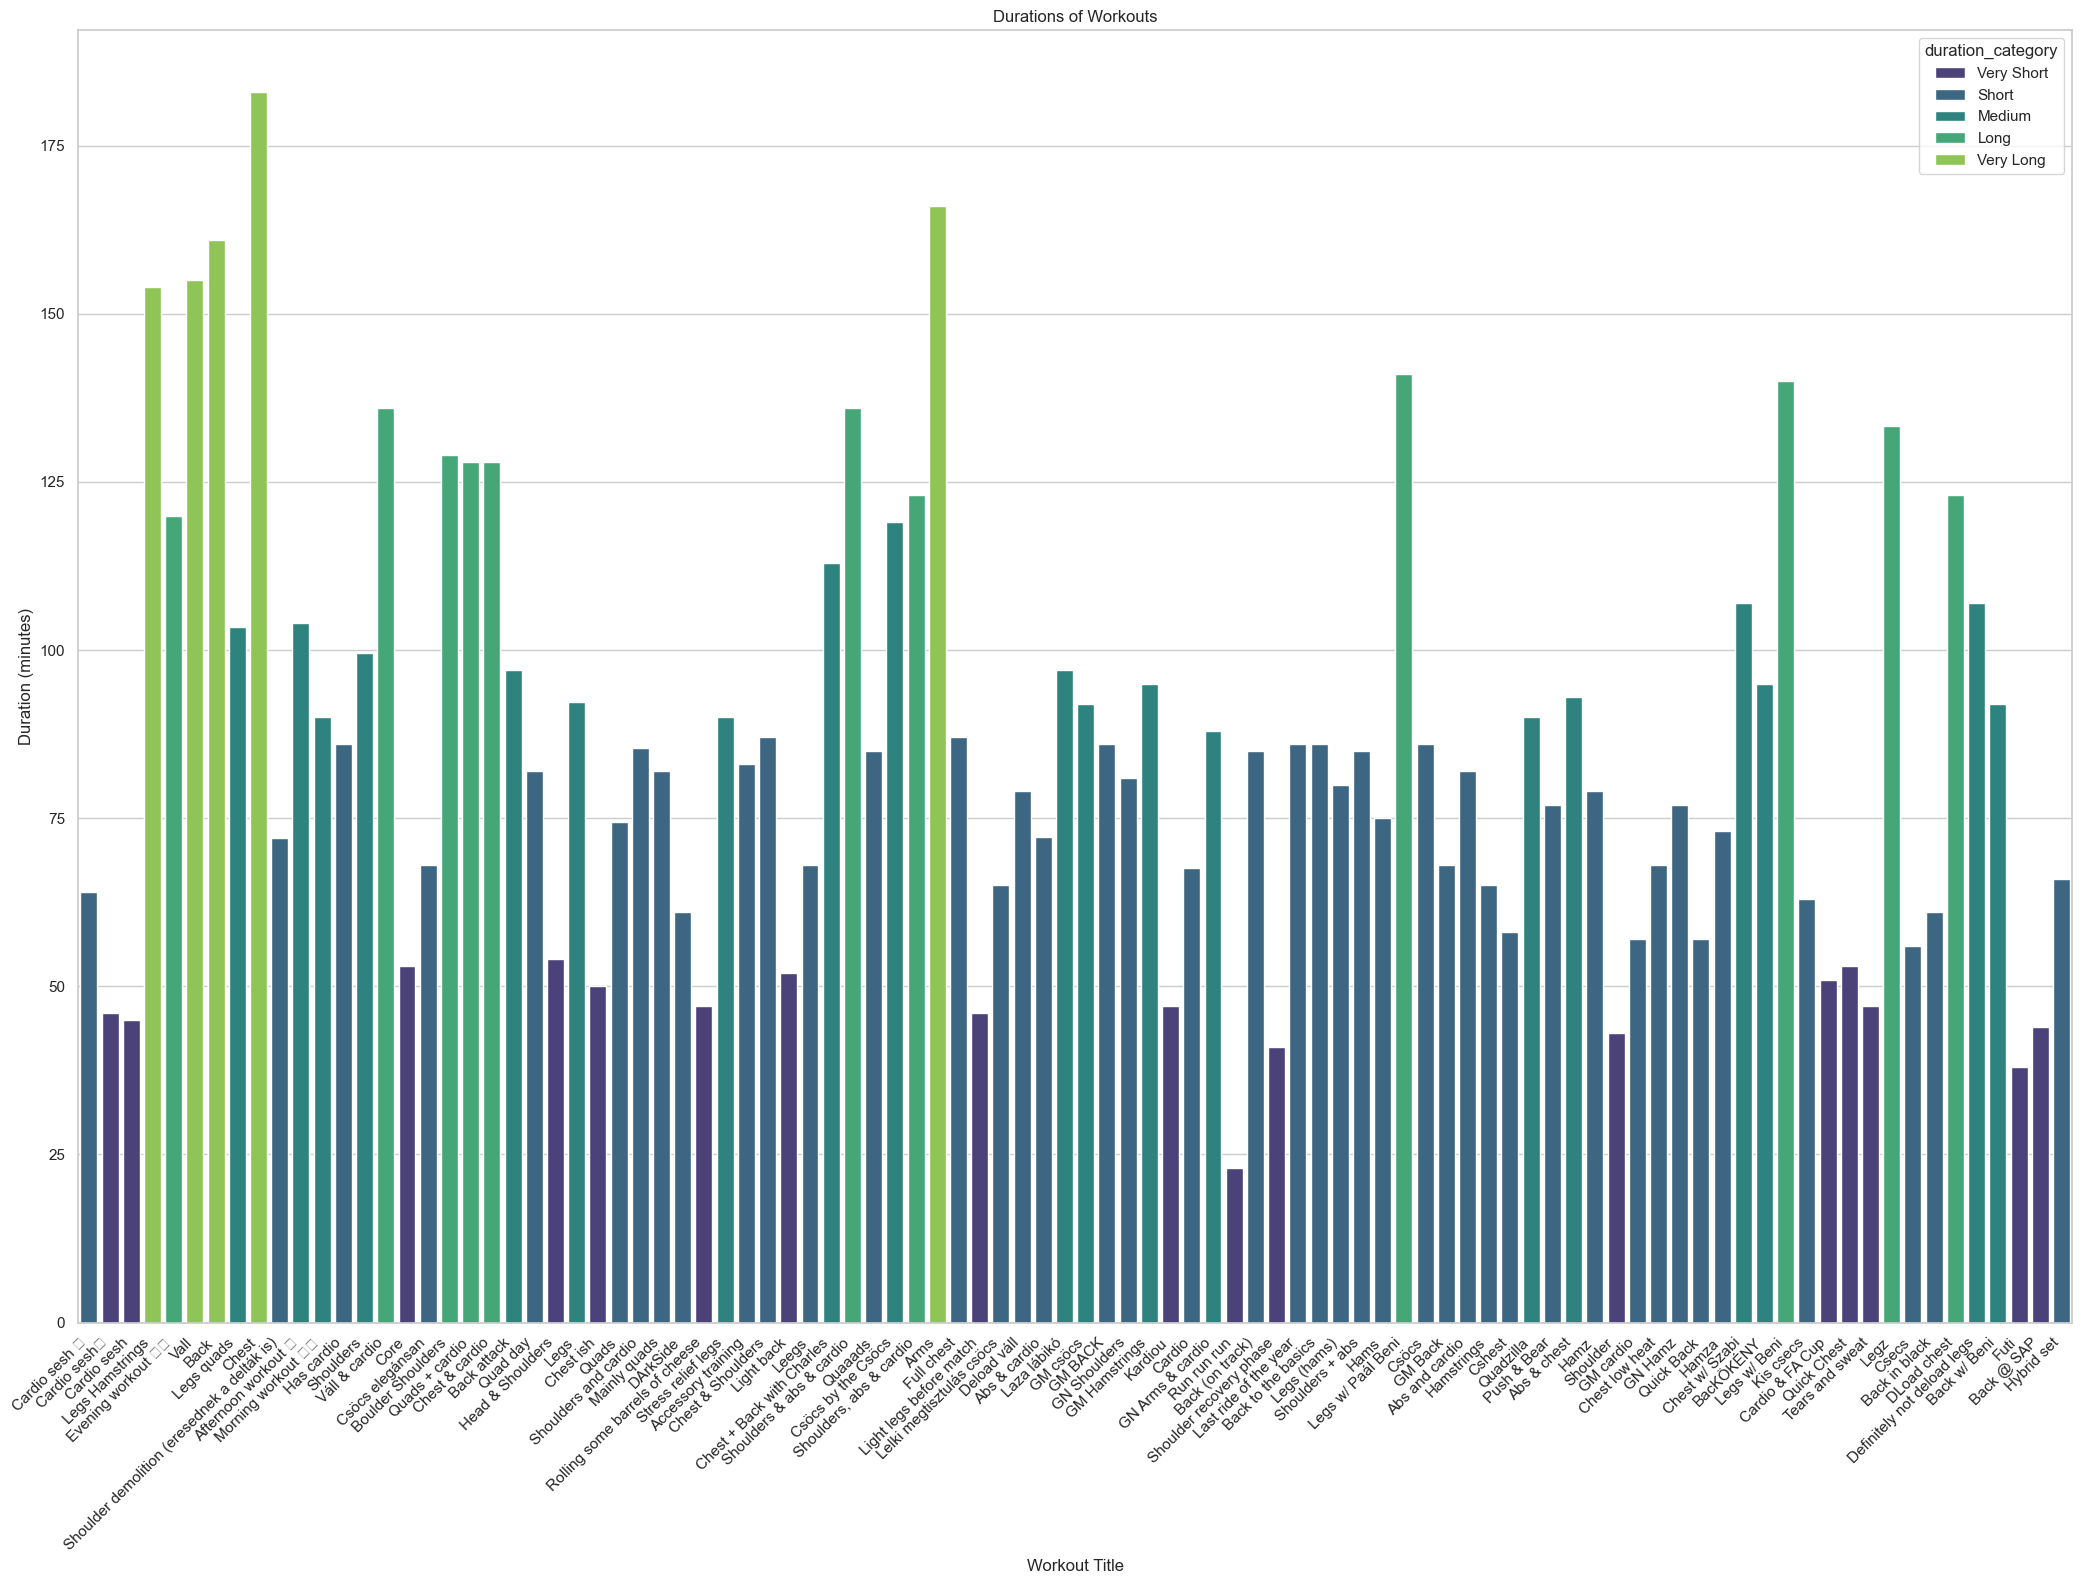

In [12]:
df['duration_category'] = pd.cut(df['workout_duration'], bins=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

sns.set_theme(style="whitegrid")

sns.barplot(x='title',
            y='workout_duration',
            hue='duration_category',
            data=df,
            palette='viridis',
            dodge=False,
            errorbar=None)


# Customize the plot
plt.xlabel('Workout Title')
plt.ylabel('Duration (minutes)')
plt.title('Durations of Workouts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

#### Volume Per Workout

C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\1288802789.py:15: UserWarning: Glyph 129397 (\N{OVERHEATED FACE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\1288802789.py:15: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\1288802789.py:15: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\1288802789.py:15: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_23468\1288802789.py:15: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from font(s) Arial.
  plt.tight_layout()
c:\projects\workout_analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129397 (\N{OVERHEATED FACE}) missing from font(s) Arial.
  fig.canvas.prin

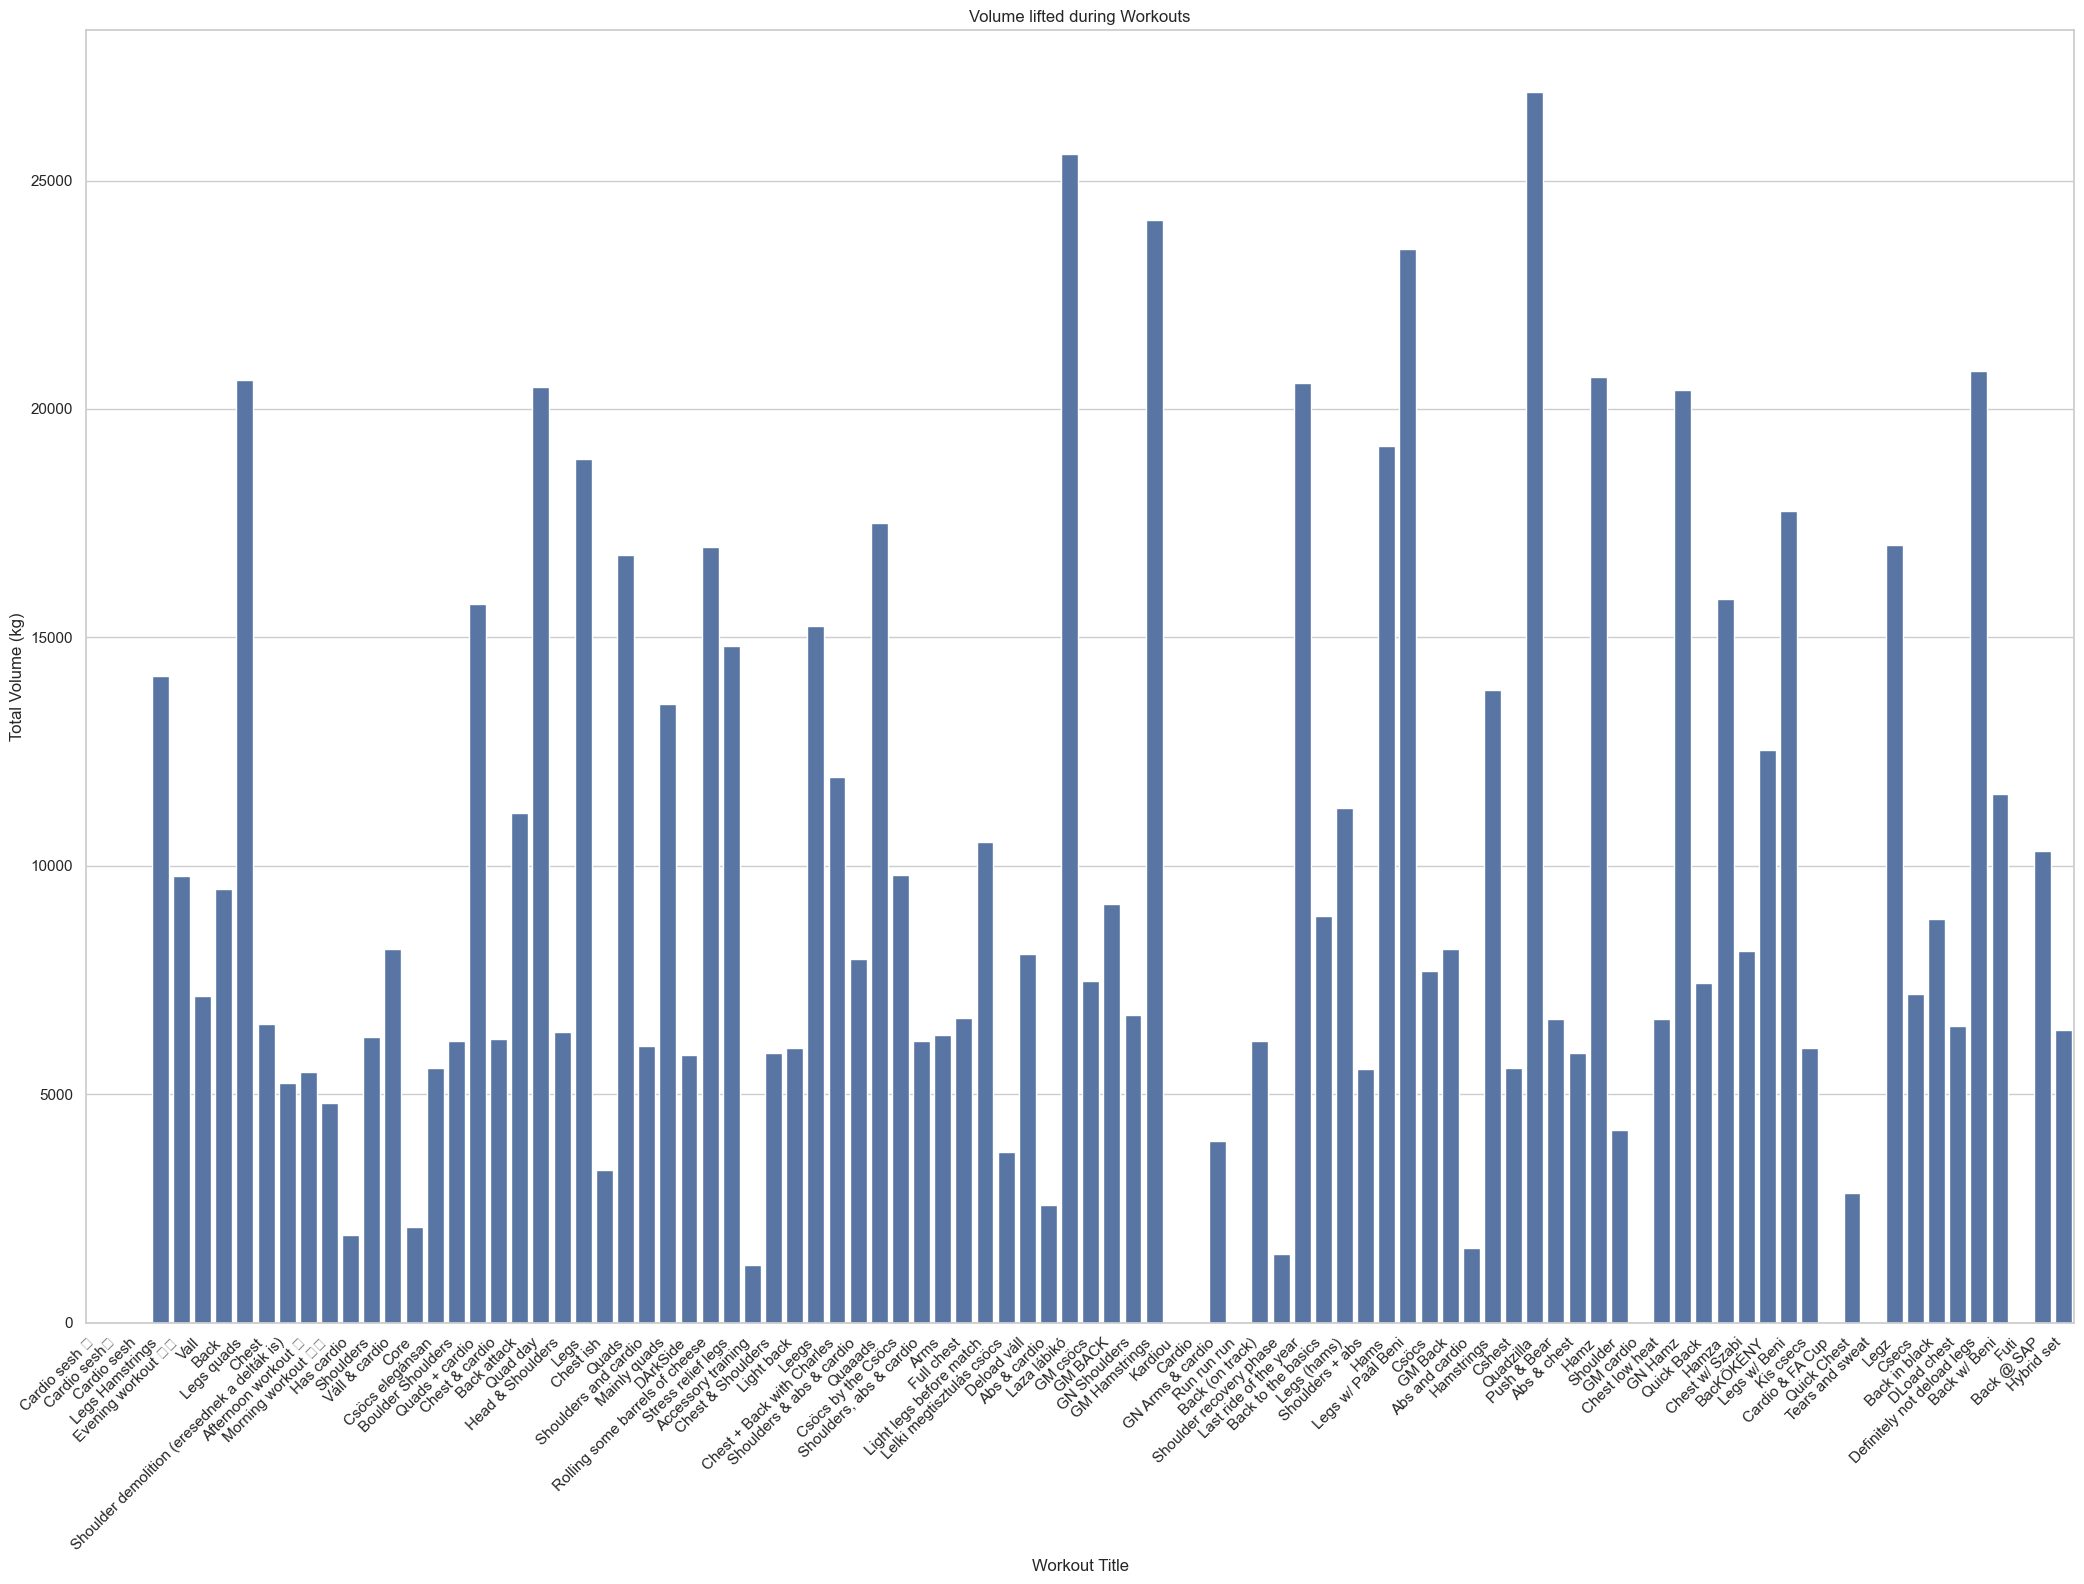

In [13]:
sns.set_theme(style="whitegrid")

sns.barplot(x='title',
            y='total_volume',
            data=df,
            dodge=False,
            errorbar=None)


# Customize the plot
plt.xlabel('Workout Title')
plt.ylabel('Total Volume (kg)')
plt.title('Volume lifted during Workouts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

#### Connection Between Volume and Duration

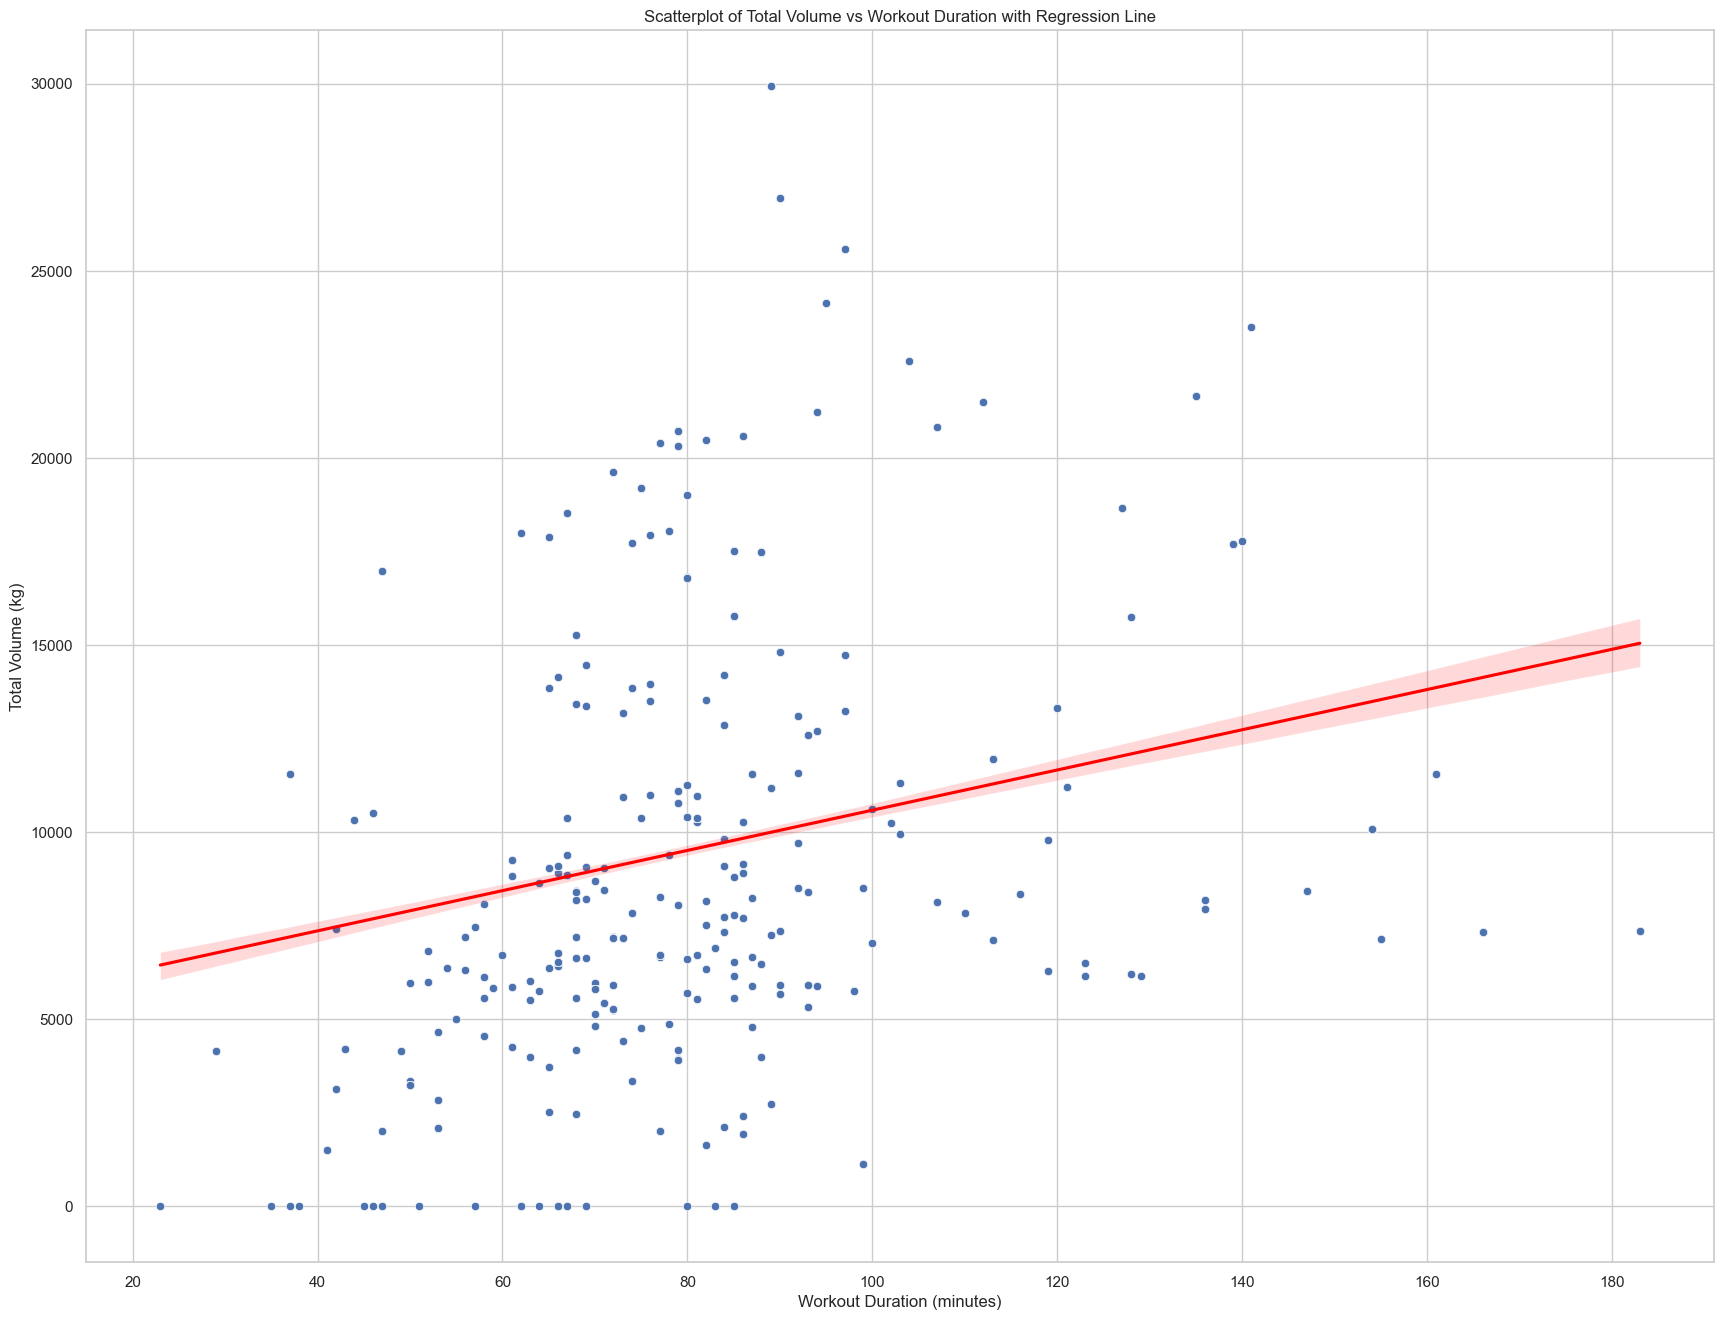

In [14]:
sns.scatterplot(x='workout_duration', y='total_volume', data=df)
sns.regplot(x='workout_duration', y='total_volume', data=df, scatter=False, color='red')
plt.xlabel('Workout Duration (minutes)')
plt.ylabel('Total Volume (kg)')
plt.title('Scatterplot of Total Volume vs Workout Duration with Regression Line')
plt.show()

<Figure size 2100x1600 with 0 Axes>

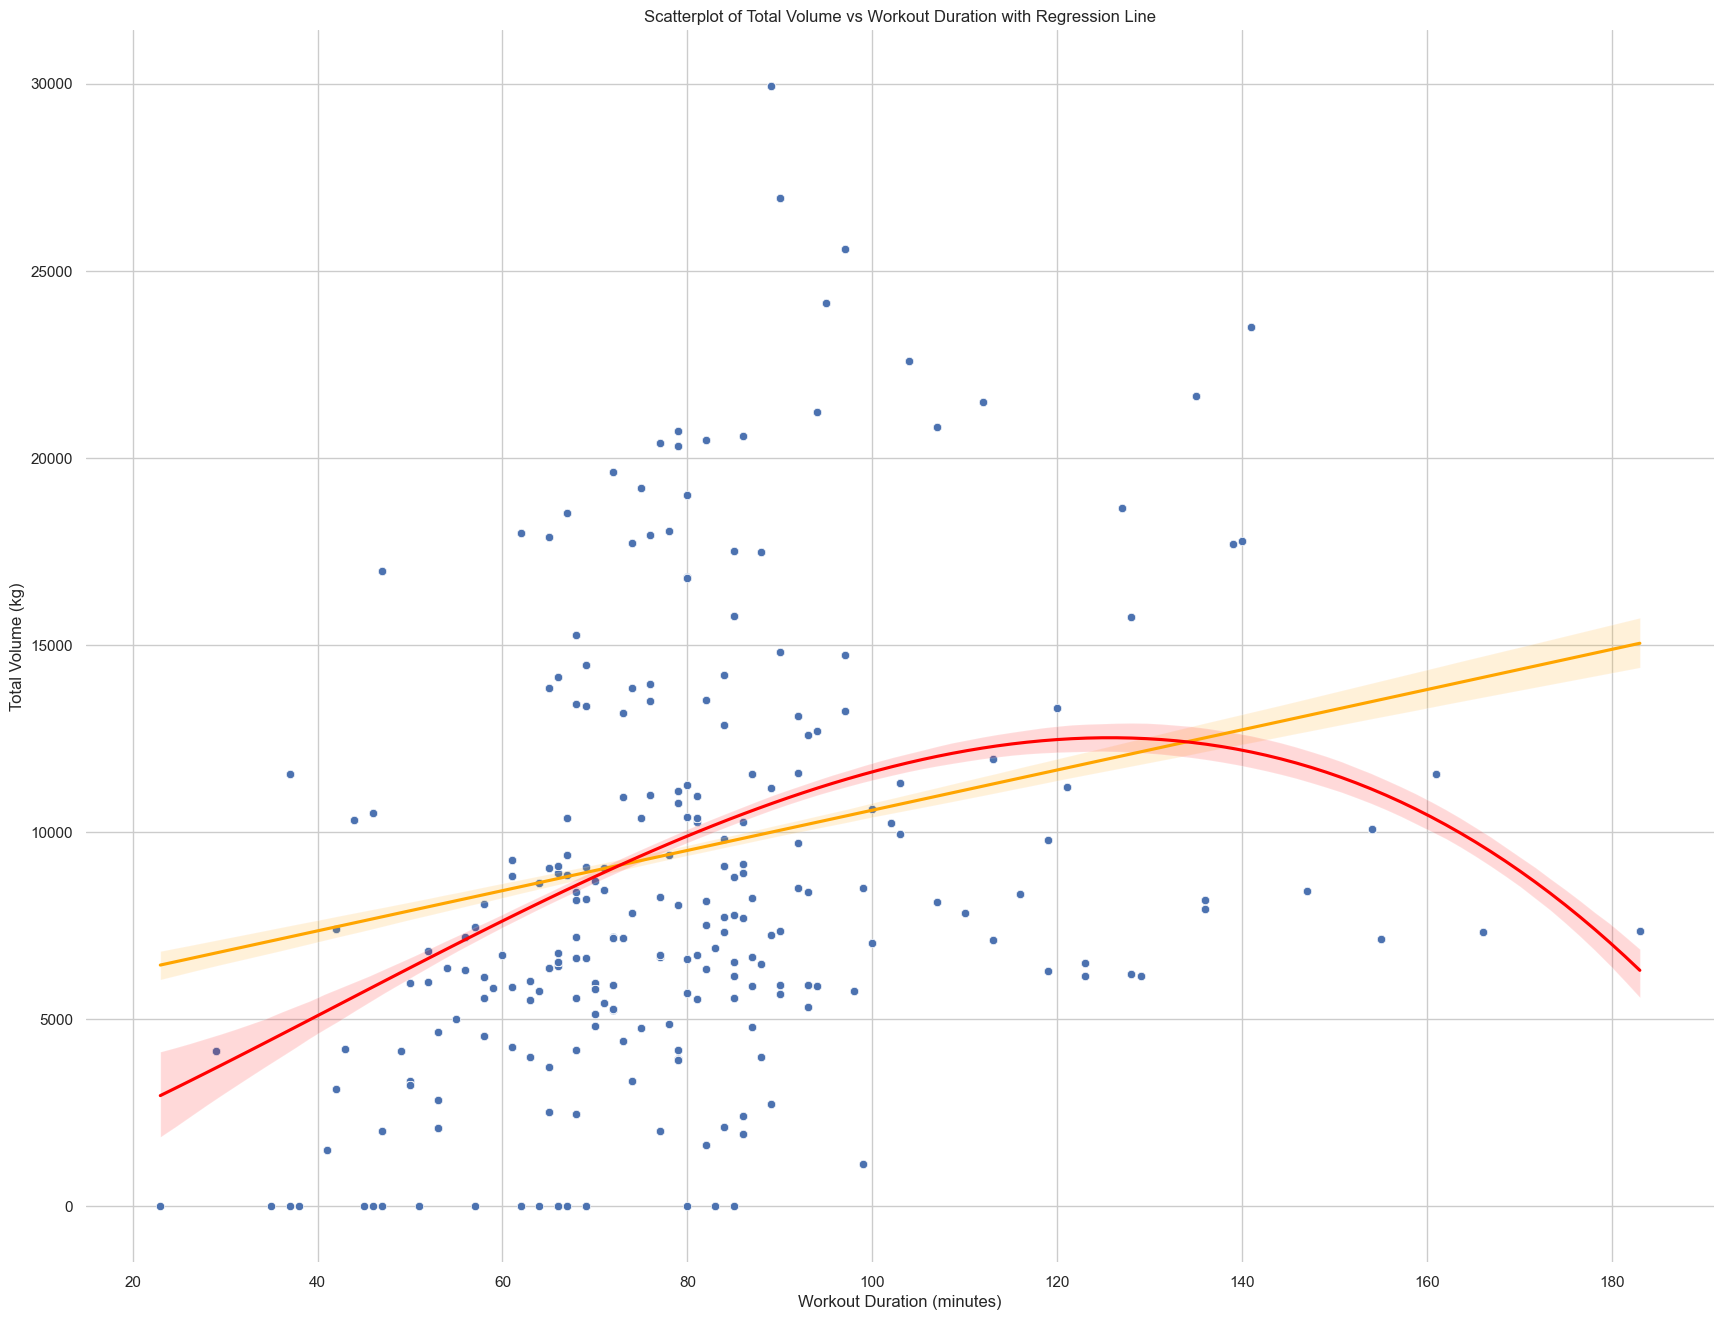

In [15]:
plt.figure(figsize=(21, 16))

f, ax = plt.subplots(figsize=(21, 16))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="workout_duration", 
                y="total_volume",
                data=df, 
                ax=ax)

sns.regplot(x="workout_duration", y="total_volume",
            data=df, 
            ax=ax, 
            scatter=False, 
            color='orange')

sns.regplot(x="workout_duration", 
            y="total_volume",
            data=df, 
            ax=ax, 
            scatter=False, 
            order=3, 
            color='red')

plt.xlabel('Workout Duration (minutes)')
plt.ylabel('Total Volume (kg)')
plt.title('Scatterplot of Total Volume vs Workout Duration with Regression Line')
plt.show()

### Clustering of features

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5141 entries, 0 to 5140
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                5141 non-null   object        
 1   start_time           5141 non-null   datetime64[ns]
 2   end_time             5141 non-null   datetime64[ns]
 3   description          5141 non-null   object        
 4   exercise_title       5141 non-null   object        
 5   superset_id          5141 non-null   object        
 6   exercise_notes       5141 non-null   object        
 7   set_index            5141 non-null   int64         
 8   set_type             5141 non-null   category      
 9   weight_kg            5141 non-null   int64         
 10  reps                 5141 non-null   int64         
 11  distance_km          5141 non-null   float64       
 12  duration_seconds     5141 non-null   int64         
 13  rpe                  5141 non-nul

#### Hierarchical Clustering

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

def encode(df: pd.DataFrame) -> pd.DataFrame:
    """Encoding the DataFrame

    Args:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: Encoded DataFrame
    """
    df_encoded = df.copy()
    for column in df_encoded.select_dtypes(include=['object', 'category', 'datetime64']):
        if column == 'start_time' or column == 'end_time':
            df_encoded[column] = df_encoded[column].astype(int) / 10**9
        else:
            df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    return df_encoded

label_encoder = LabelEncoder()

grouped_df = df.groupby('title').agg({'workout_duration': 'mean', 'total_volume': 'mean'}).reset_index()

df_encoded = encode(grouped_df.copy())

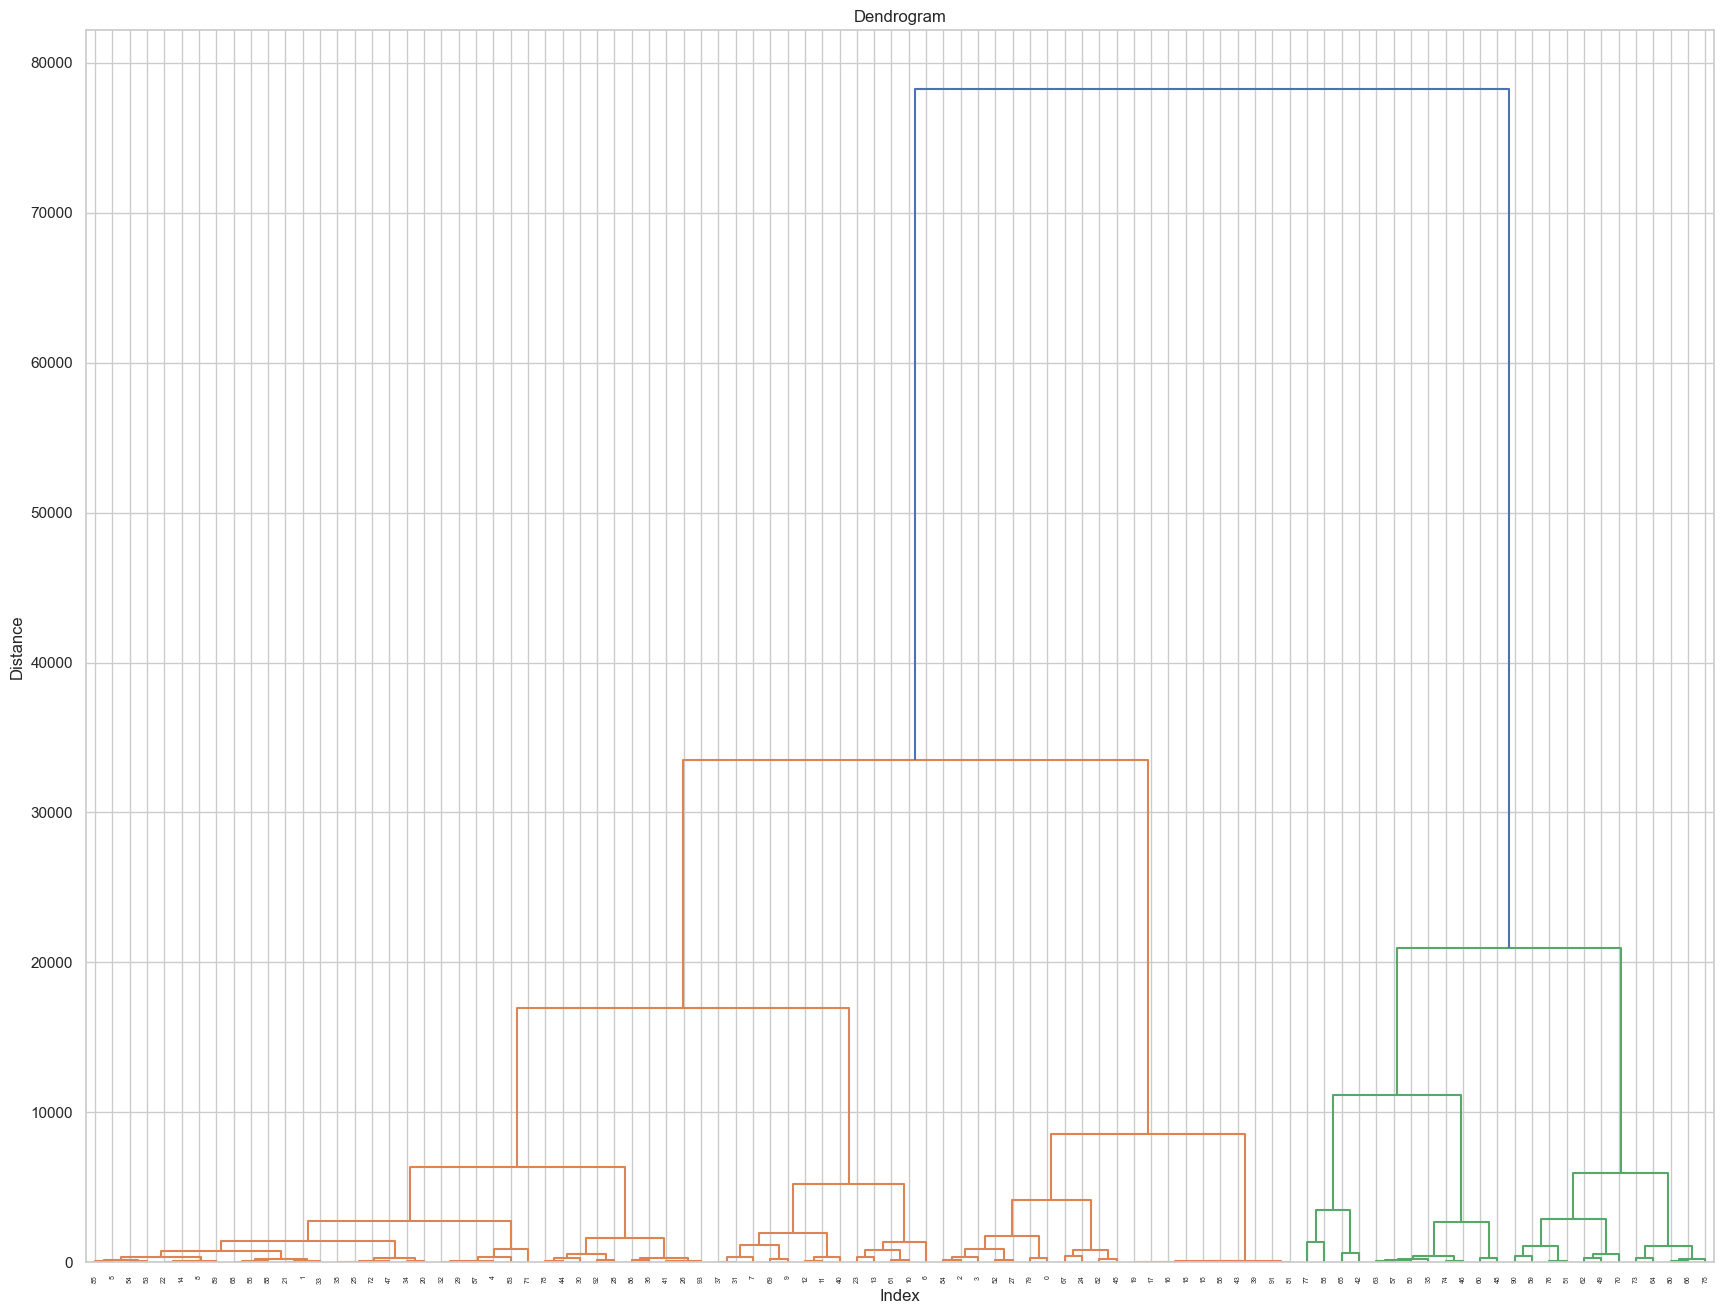

In [18]:
hierarchical_clustering = AgglomerativeClustering(n_clusters = 5)
hierarchy_cluster = hierarchical_clustering.fit_predict(df_encoded)
linked = linkage(df_encoded, method='ward')

# Plot the dendrogram
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

In [19]:
n_clusters = 7
kmeans = KMeans(n_clusters = n_clusters, 
                random_state = 0).fit(encode(df.copy()))

kmeans.labels_

df['cluster'] = kmeans.labels_

In [20]:
kmeans.cluster_centers_[:, df.columns.get_loc('workout_duration')]

array([ 84.72279793,  83.86545455,  83.22992701, 103.19674185,
        71.62135922,  73.43937419,  82.69457547])

In [21]:
kmeans.cluster_centers_[:, df.columns.get_loc('total_volume')]

array([ 9337.64637306, 10112.45090909,  9712.36131387,  9768.12907268,
       10194.55016181,  9926.45241199,  9440.61910377])

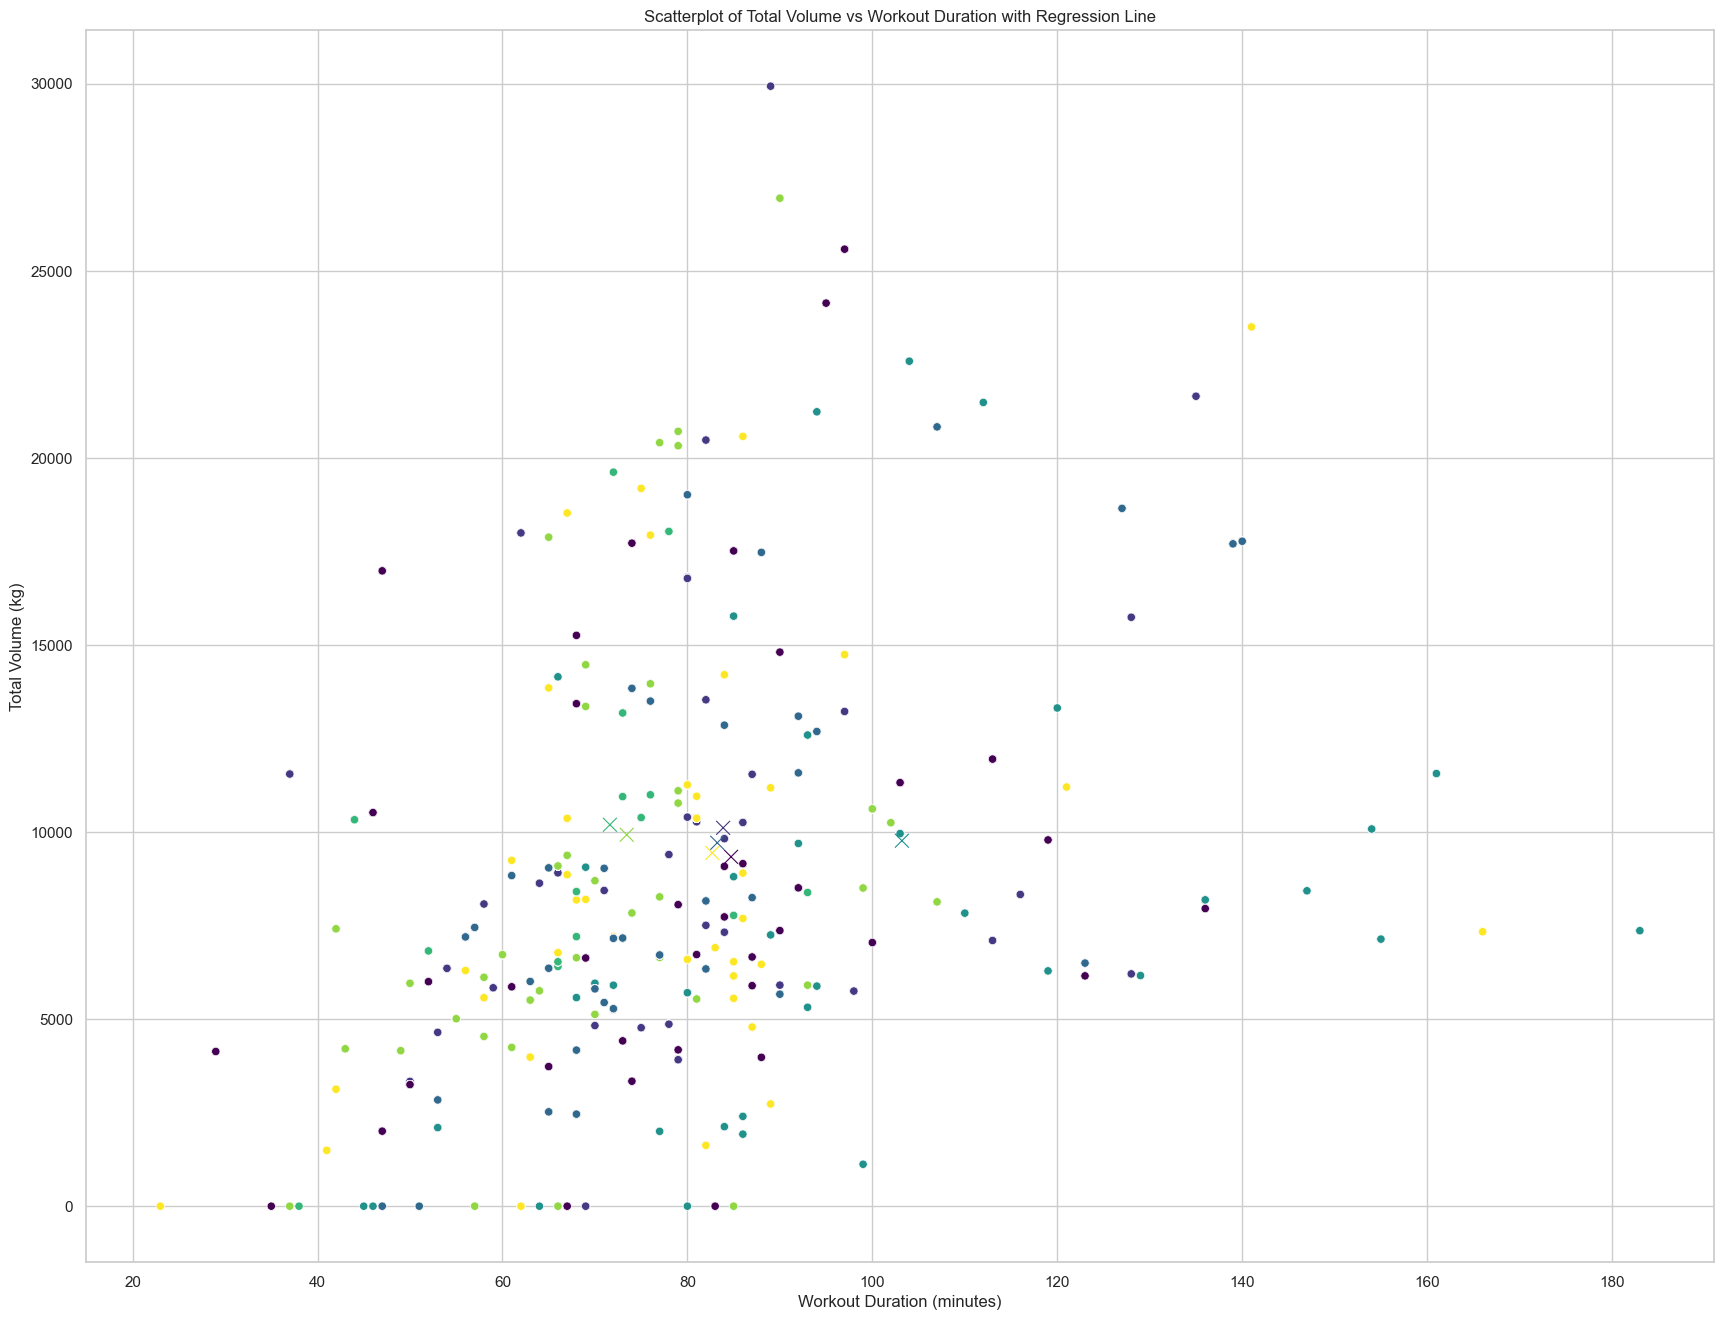

In [22]:
sns.scatterplot(x='workout_duration', y='total_volume', data=df, hue='cluster', palette='viridis')
sns.scatterplot(x = kmeans.cluster_centers_[:, df.columns.get_loc('workout_duration')],  
                y = kmeans.cluster_centers_[:, df.columns.get_loc('total_volume')], 
                hue=range(7),
                palette='viridis',
                s = 100, 
                marker = 'x')

plt.xlabel('Workout Duration (minutes)')
plt.ylabel('Total Volume (kg)')
plt.title('Scatterplot of Total Volume vs Workout Duration with Regression Line')
plt.legend().remove()
plt.show()